In [32]:
import os

import numpy as np
import pandas as pd
import cv2
import math
import matplotlib.pyplot as plt

In [33]:
train_data= pd.read_csv("../ELEC576project/sartorius-cell-instance-segmentation/train.csv")

In [34]:
def rotate_image(image, angle):
    
    # Get the image size
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result

In [35]:
def largest_rotated_rect(w, h, angle):
    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )

In [36]:
def crop_around_center(image, width, height):

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

(-0.5, 250.5, 250.5, -0.5)

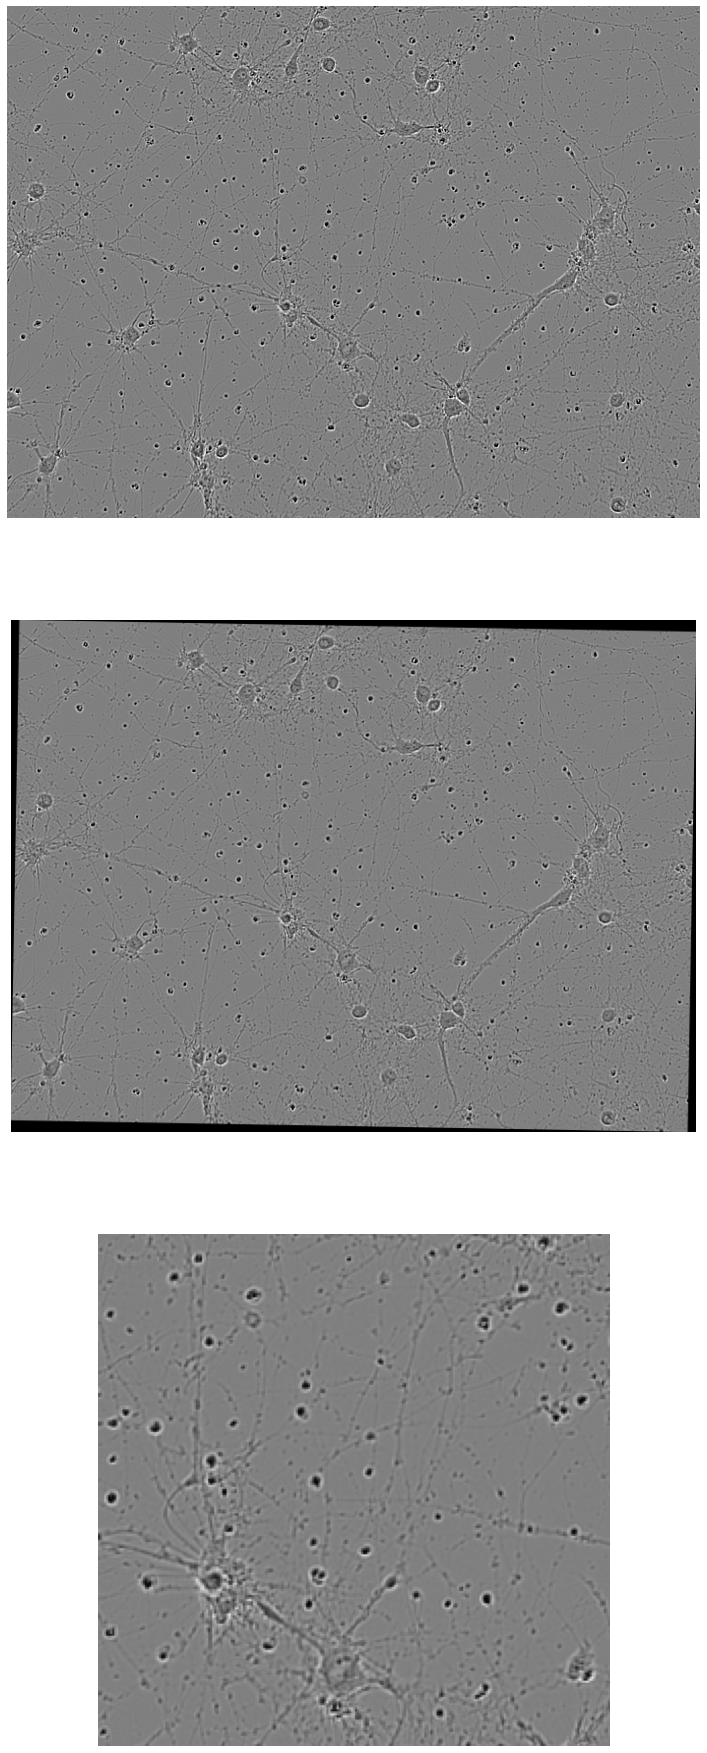

In [37]:
id = "0ba181d412da"
sample_image_df = train_data[train_data['id'] == id]
sample_path = f"../ELEC576project/sartorius-cell-instance-segmentation/train/{sample_image_df['id'].iloc[0]}/{sample_image_df['id'].iloc[0]}.png"
image = cv2.imread(sample_path,cv2.IMREAD_COLOR)
image_height, image_width = image.shape[0:2]

for i in np.arange(0, 360, 1):
    image_orig = np.copy(image)
    image_rotated = rotate_image(image, i)
    image_rotated_cropped = crop_around_center(
        image_rotated,
        *largest_rotated_rect(
            256,
            256,
            math.radians(i)
        )
    )

plt.figure(figsize=(16, 32))
plt.subplot(3, 1, 1)
plt.imshow(image_orig) 
plt.axis("off")
plt.subplot(3, 1, 2)
plt.imshow(image_rotated) 
plt.axis("off")
plt.subplot(3, 1, 3)
plt.imshow(image_rotated_cropped) 
plt.axis("off")
